# Uncertainties and Randomization Demo

In [1]:
from sorcha.modules.PPAddUncertainties import addUncertainties
from sorcha.modules.PPRandomizeMeasurements import randomizeAstrometry
from sorcha.modules.PPModuleRNG import PerModuleRNG

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

This notebook demonstrates the uncertainties calculation and the randomisation of object position and magnitude based on the calculated uncertainties.

First we create the data. The expected LSST limiting magnitude for a single exposure in the g-band is 25 - we will extend our magnitude range to 30 for demonstrative purposes. The objects have identical position, velocity, seeing and limiting magnitude at the source position: uncertainties will thus depend on magnitude alone.

In [3]:
obj_ids = np.arange(0, 1000)
obj_mags = np.linspace(15, 30, 1000)
psf_mags = obj_mags + 0.01
sig_limit = np.ones(len(obj_ids)) + 23.
seeing = np.ones(len(obj_ids))
astRArate = np.ones(len(obj_ids)) + 0.03
astDecrate = np.ones(len(obj_ids)) - 0.01
astRA = np.ones(len(obj_ids)) + 260.
astDec = np.ones(len(obj_ids)) -5.

In [4]:
observations = pd.DataFrame({'ObjID': obj_ids,
                             'TrailedSourceMag': obj_mags,
                             'PSFMag': psf_mags,
                             'fiveSigmaDepthAtSource': sig_limit,
                             'seeingFwhmGeom': seeing,
                             'seeingFwhmEff': seeing,
                             'AstRARate(deg/day)': astRArate,
                             'AstDecRate(deg/day)': astDecrate,
                             'AstRA(deg)': astRA,
                             'AstDec(deg)': astDec})

In [5]:
observations.columns

Index(['ObjID', 'TrailedSourceMag', 'PSFMag', 'fiveSigmaDepthAtSource',
       'seeingFwhmGeom', 'seeingFwhmEff', 'AstRARate(deg/day)',
       'AstDecRate(deg/day)', 'AstRA(deg)', 'AstDec(deg)'],
      dtype='object')

As can be seen from the columns, both TrailedSourceMag (the magnitude of the source including any trailing) and PSFMag (the magnitude of the object within the PSF-fitting kernel) are included here. The code will calculate the uncertainties for each one.

In [6]:
configs = {'trailing_losses_on':True, 'default_SNR_cut': False}
rng = PerModuleRNG(2012)

In [7]:
obs_uncert = addUncertainties(observations, configs, rng)

In [8]:
obs_uncert.columns

Index(['ObjID', 'TrailedSourceMag', 'PSFMag', 'fiveSigmaDepthAtSource',
       'seeingFwhmGeom', 'seeingFwhmEff', 'AstRARate(deg/day)',
       'AstDecRate(deg/day)', 'AstRA(deg)', 'AstDec(deg)',
       'AstrometricSigma(deg)', 'PhotometricSigmaTrailedSource(mag)', 'SNR',
       'PhotometricSigmaPSF(mag)', 'observedTrailedSourceMag',
       'observedPSFMag'],
      dtype='object')

In [9]:
obs_uncert

,ObjID,TrailedSourceMag,PSFMag,fiveSigmaDepthAtSource,seeingFwhmGeom,seeingFwhmEff,AstRARate(deg/day),AstDecRate(deg/day),AstRA(deg),AstDec(deg),AstrometricSigma(deg),PhotometricSigmaTrailedSource(mag),SNR,PhotometricSigmaPSF(mag),observedTrailedSourceMag,observedPSFMag
0,0,15.000000,15.010000,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.000003,0.000677,1595.732172,0.000680,15.000116,15.009979
1,1,15.015015,15.025015,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.000003,0.000682,1584.572286,0.000685,15.015128,15.025376
2,2,15.030030,15.040030,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.000003,0.000687,1573.488214,0.000690,15.030910,15.039236
3,3,15.045045,15.055045,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.000003,0.000691,1562.479428,0.000695,15.045741,15.056046
4,4,15.060060,15.070060,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.000003,0.000696,1551.545403,0.000700,15.059227,15.070627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,29.939940,29.949940,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.011938,4.652802,0.013832,4.662665,29.850523,33.208523
996,996,29.954955,29.964955,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.012105,4.667611,0.013643,4.677476,24.605982,27.878692
997,997,29.969970,29.979970,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.012273,4.682423,0.013455,4.692289,37.810369,31.596365
998,998,29.984985,29.994985,24.0,1.0,1.0,1.03,0.99,261.0,-4.0,0.012444,4.697238,0.013270,4.707106,31.139703,23.027997


As can be seen from the above, we have several new columns:

**observedTrailedSourceMag/observedPSFMag:** a randomised magnitude as 'observed' by the telescope, based on the 'true' magnitude and its calculated uncertainty

**PhotometricSigmaTrailedSource(mag)/PhotometricSigmaPSF(mag):** the uncertainty on the magnitude measurement

**AstrometricSigma(deg):** the uncertainty on the object position

**SNR:** the signal-to-noise ratio.

Let's take a look at these, starting with the SNR. For all plots, the single-exposure limiting magnitude in g-band (25) is marked.

Text(0, 0.5, 'SNR')

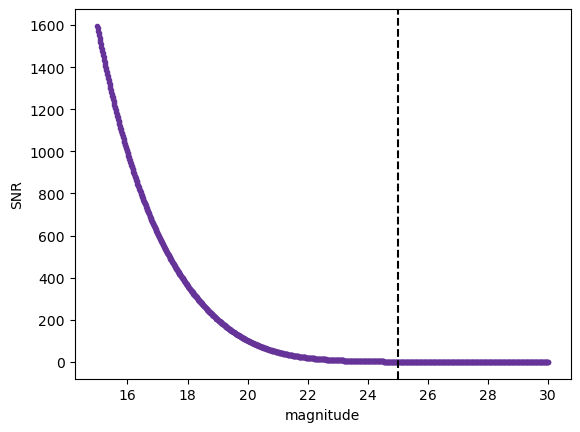

In [10]:
fig, ax = plt.subplots(1)
ax.plot(obs_uncert['TrailedSourceMag'].values, obs_uncert['SNR'].values, linestyle='', marker='.', color='rebeccapurple')
ax.axvline(25, color='black', linestyle='--')
ax.set_xlabel('magnitude')
ax.set_ylabel('SNR')

The photometric uncertainty for the trailed source and PSF magnitudes:

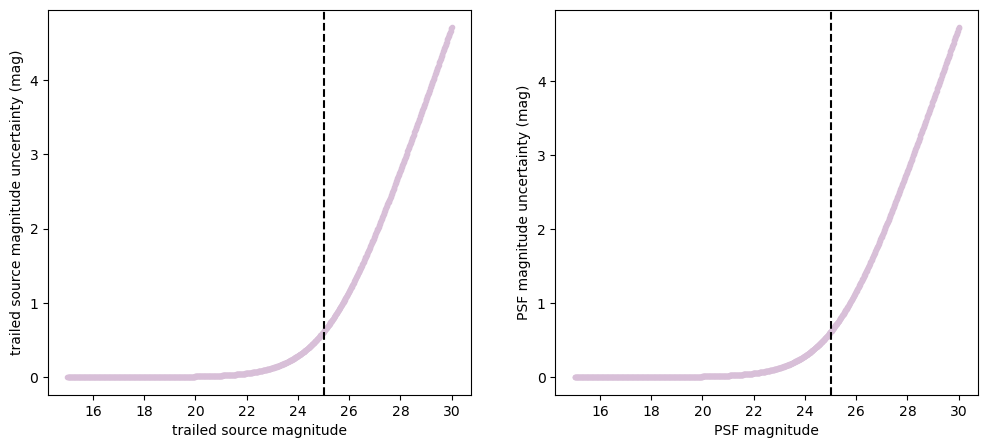

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(obs_uncert['TrailedSourceMag'].values, obs_uncert['PhotometricSigmaTrailedSource(mag)'].values, linestyle='', marker='.', color='thistle')
ax[0].set_xlabel('trailed source magnitude')
ax[0].set_ylabel('trailed source magnitude uncertainty (mag)')
ax[0].axvline(25, color='black', linestyle='--')
ax[1].plot(obs_uncert['PSFMag'].values, obs_uncert['PhotometricSigmaPSF(mag)'].values, linestyle='', marker='.', color='thistle')
ax[1].set_xlabel('PSF magnitude')
ax[1].set_ylabel('PSF magnitude uncertainty (mag)')
ax[1].axvline(25, color='black', linestyle='--')

Astrometric uncertainty:

Text(0, 0.5, 'astrometric uncertainty (deg)')

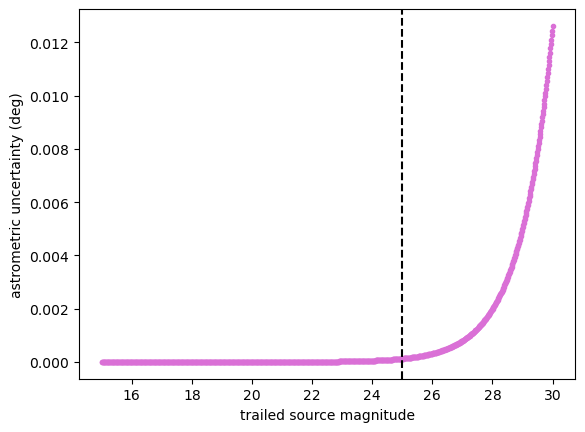

In [12]:
fig, ax = plt.subplots(1)
ax.plot(obs_uncert['TrailedSourceMag'].values, obs_uncert['AstrometricSigma(deg)'].values, linestyle='', marker='.', color='orchid')
ax.axvline(25, color='black', linestyle='--')
ax.set_xlabel('trailed source magnitude')
ax.set_ylabel('astrometric uncertainty (deg)')

Next we look at the randomisation of the magnitude based on the uncertainties, for both trailed source and PSF magnitudes. Note that for large magnitudes, and thus large photometric uncertainties, the randomisation leads to very large shifts in the magnitude. However, this only occurs for objects fainter than LSST's single exposure limiting magnitude - the SNR of these objects is so low that by default, SSPP will remove them from contention.

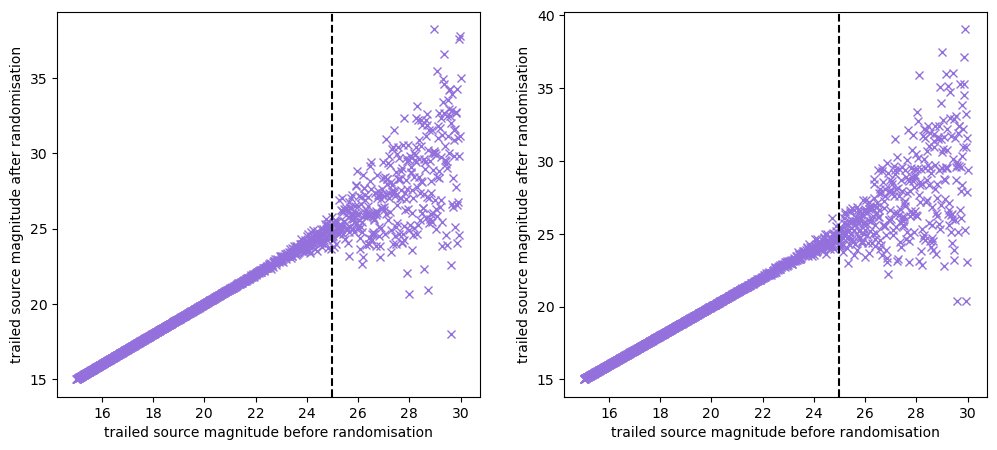

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(obs_uncert['TrailedSourceMag'].values, obs_uncert['observedTrailedSourceMag'].values, linestyle="", marker="x", color='mediumpurple')
ax[0].set_xlabel('trailed source magnitude before randomisation')
ax[0].set_ylabel('trailed source magnitude after randomisation')
ax[0].axvline(25, color='black', linestyle='--')
ax[1].plot(obs_uncert['PSFMag'].values, obs_uncert['observedPSFMag'].values, linestyle="", marker="x", color='mediumpurple')
ax[1].set_xlabel('trailed source magnitude before randomisation')
ax[1].set_ylabel('trailed source magnitude after randomisation')
ax[1].axvline(25, color='black', linestyle='--')

A separate function then randomises the object position based on its astrometric uncertainty. We will recreate the data to have the same magnitude, but vary RA and Dec.

In [14]:
obj_ids = np.arange(0, 1000)
obj_mags = np.ones(len(obj_ids)) + 21.
psf_mags = obj_mags + 0.01
sig_limit = np.ones(len(obj_ids)) + 23.
seeing = np.ones(len(obj_ids))
astRArate = np.ones(len(obj_ids)) + 0.03
astDecrate = np.ones(len(obj_ids)) - 0.01
astRA = np.linspace(0, 360, 1000)
astDec = np.linspace(-90, 0, 1000)

In [15]:
observations = pd.DataFrame({'ObjID': obj_ids,
                             'TrailedSourceMag': obj_mags,
                             'PSFMag': psf_mags,
                             'fiveSigmaDepthAtSource': sig_limit,
                             'seeingFwhmGeom': seeing,
                             'seeingFwhmEff': seeing,
                             'AstRARate(deg/day)': astRArate,
                             'AstDecRate(deg/day)': astDecrate,
                             'AstRA(deg)': astRA,
                             'AstDec(deg)': astDec})

In [16]:
observations = addUncertainties(observations, configs, rng)

In [17]:
observations = randomizeAstrometry(observations, rng, sigName='AstrometricSigma(deg)', sigUnits='deg')

In [18]:
true_coord = SkyCoord(ra=observations['AstRATrue(deg)'].values, dec=observations['AstDecTrue(deg)'].values, unit="deg")
random_coord = SkyCoord(ra=observations['AstRA(deg)'].values, dec=observations['AstDec(deg)'].values, unit="deg")

separation = true_coord.separation(random_coord).mas

Text(0.5, 0, 'difference between true and randomised position (mas)')

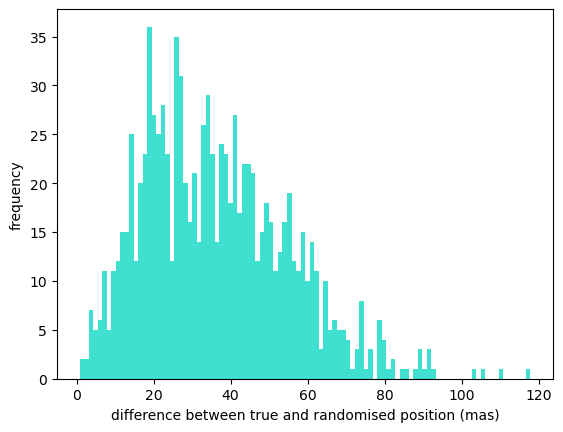

In [19]:
fig, ax = plt.subplots(1)
ax.hist(separation, 100, color='turquoise')
ax.set_ylabel('frequency')
ax.set_xlabel('difference between true and randomised position (mas)')